In [3]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
import corner
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from IPython.display import display, Math
from astropy.io import fits

In [5]:
data = np.genfromtxt("jla_lcparams.txt", delimiter=" ", usemask=False).transpose()

In [7]:
zcmb, zhel, dz, mb, dmb, x1, dx1, color, dcolor, thirdvar, dthirdvar, tmax, dtmax, cov_m_s, cov_m_c, cov_s_c, set, ra, dec, biascor = data[1], data[2], data[3], data[4], data[5], data[6], data[7], data[8], data[9], data[10], data[11], data[12], data[13], data[14], data[15], data[16], data[17], data[18], data[19], data[20]  

In [9]:
hdul = fits.open('C_stat.fits')
COV = hdul[0].data

In [11]:
C00 = np.delete(np.genfromtxt("jla_v0_covmatrix.dat", usemask=False), 0)
C11 = np.delete(np.genfromtxt("jla_va_covmatrix.dat", usemask=False), 0)
C22 = np.delete(np.genfromtxt("jla_vb_covmatrix.dat", usemask=False), 0)
C01 = np.delete(np.genfromtxt("jla_v0a_covmatrix.dat", usemask=False), 0)
C02 = np.delete(np.genfromtxt("jla_v0b_covmatrix.dat", usemask=False), 0)
C12 = np.delete(np.genfromtxt("jla_vab_covmatrix.dat", usemask=False), 0)

In [25]:
data = np.genfromtxt('sigma_mu.txt', delimiter=' ', usemask=False).transpose()
sigma_coh, sigma_lens = data[0], data[2]
diagerr = np.diagflat(sigma_coh*sigma_coh) + np.diagflat(sigma_lens*sigma_lens)

In [31]:
ifmass = np.array([])

for i in thirdvar:
    if i>=10:
        ifmass = np.block([ifmass, 1])
    else:
        ifmass = np.block([ifmass, 0])

repe = 3*np.ones(740, dtype=np.int8)

In [33]:
def mu_lcdm(z,Om):
    cosmo = FlatLambdaCDM(H0=70, Om0=Om)
    return 5*np.log10((cosmo.luminosity_distance(z).to_value(u.pc)/(10*u.pc)).value)

In [115]:
def mu_dat(mb, x1, color, M1b, dM1b, alpha, beta):
    return mb - (M1b + dM1b*ifmass) + alpha*x1 - beta*color

def err2_mu(dmb, alpha, dx1, beta, dcolor, cov_m_s, cov_m_c, cov_s_c):
    return dmb*dmb + alpha*alpha*dx1*dx1 + beta*beta*dcolor*dcolor + 2*alpha*cov_m_s - 2*alpha*beta*cov_s_c - 2*beta*cov_m_c

def Amat(alpha, beta):
    iden = np.identity(740)
    Ahor = np.array([1,alpha,-beta])
    A = np.tensordot(iden, Ahor, axes = 0).reshape((740,2220))

    return A

def cov(sigma_mu, alpha, beta):
    cov = C00 + alpha*alpha*C11 + beta*beta*C22 + 2*alpha*C01 - 2*beta*C02 - 2*alpha*beta*C12
    cov = cov.reshape((740,740))
    cov = cov + np.diagflat(sigma_mu)

    #cov = np.repeat(np.repeat(cov, repe, axis=1), repe, axis=0)

    #A = Amat(alpha, beta)
    #cov = np.matmul(A,np.matmul(cov,A.transpose()))

    return cov

In [149]:
def log_likelihood(theta, zcmb, mb, dmb, x1, dx1, color, dcolor, thirdvar, cov_m_s, cov_m_c, cov_s_c):
    
    Om, alpha, beta, M1b, dM1b = theta
    
    mulcdm = mu_lcdm(zcmb, Om)
    mudat = mu_dat(mb, x1, color, M1b, dM1b, alpha, beta)
    res = mudat - mulcdm

    #Eror calculado como en c++
    sigma_mu = err2_mu(dmb, alpha, dx1, beta, dcolor, cov_m_s, cov_m_c, cov_s_c)
    incov = np.linalg.inv(cov(sigma_mu, alpha, beta))

    #Error de la matriz que da el dataset
    #A = Amat(alpha, beta) 
    #incov = np.linalg.inv(np.matmul(A,np.matmul(COV,A.transpose())) + diagerr)

    #Error Diagonal (solo derivadas)
    #sigma_mu = err2_mu(dmb, alpha, dx1, beta, dcolor, cov_m_s, cov_m_c, cov_s_c) + diagerr
    #incov = np.linalg.inv(np.diagflat(sigma_mu))

    xisq = np.matmul(res.transpose(), np.matmul(incov, res))
    
    return -xisq

In [119]:
def log_prior(theta):
    Om, alpha, beta, M1b, dM1b = theta
    if 0.1 < Om < 0.5 and 0 < alpha < 0.5 and 1 < beta < 5 and -25 < M1b < -17 and -0.6 < dM1b < 0.0:
        return 0.0
    return -np.inf

In [121]:
def log_probability(theta, zcmb, mb, dmb, x1, dx1, color, dcolor, thirdvar, cov_m_s, cov_m_c, cov_s_c):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, zcmb, mb, dmb, x1, dx1, color, dcolor, thirdvar, cov_m_s, cov_m_c, cov_s_c)

In [123]:
def mcmc(p, nwalkers, niter, ndim, nburn, log_probability, zcmb, mb, dmb, x1, dx1, color, dcolor, thirdvar, cov_m_s, cov_m_c, cov_s_c):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(zcmb, mb, dmb, x1, dx1, color, dcolor, thirdvar, cov_m_s, cov_m_c, cov_s_c))

    print("Running burn-in...")
    p, _, _ = sampler.run_mcmc(p, nburn, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p, niter, progress=True)

    return sampler, pos, prob, state

In [183]:
nwalkers = 100
niter = 100
nburn = 200

initial = [0.2, 0.2, 2, -21, -0.4]

ndim = len(initial)
p0 = [np.array(initial) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]

In [188]:
sampler, pos, prob, state = mcmc(p0, nwalkers, niter, ndim, nburn, log_probability, zcmb, mb, dmb, x1, dx1, color, dcolor, thirdvar, cov_m_s, cov_m_c, cov_s_c)

Running burn-in...


100%|█████████████████████████████████████████| 200/200 [16:38<00:00,  4.99s/it]


Running production...


100%|█████████████████████████████████████████| 100/100 [08:54<00:00,  5.34s/it]


In [189]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([  0.29107965,   0.14104608,   3.10431952, -19.05080445,
        -0.0689967 ])

In [190]:
sampler.flatlnprobability[np.argmax(sampler.flatlnprobability)]

-682.9044268044545

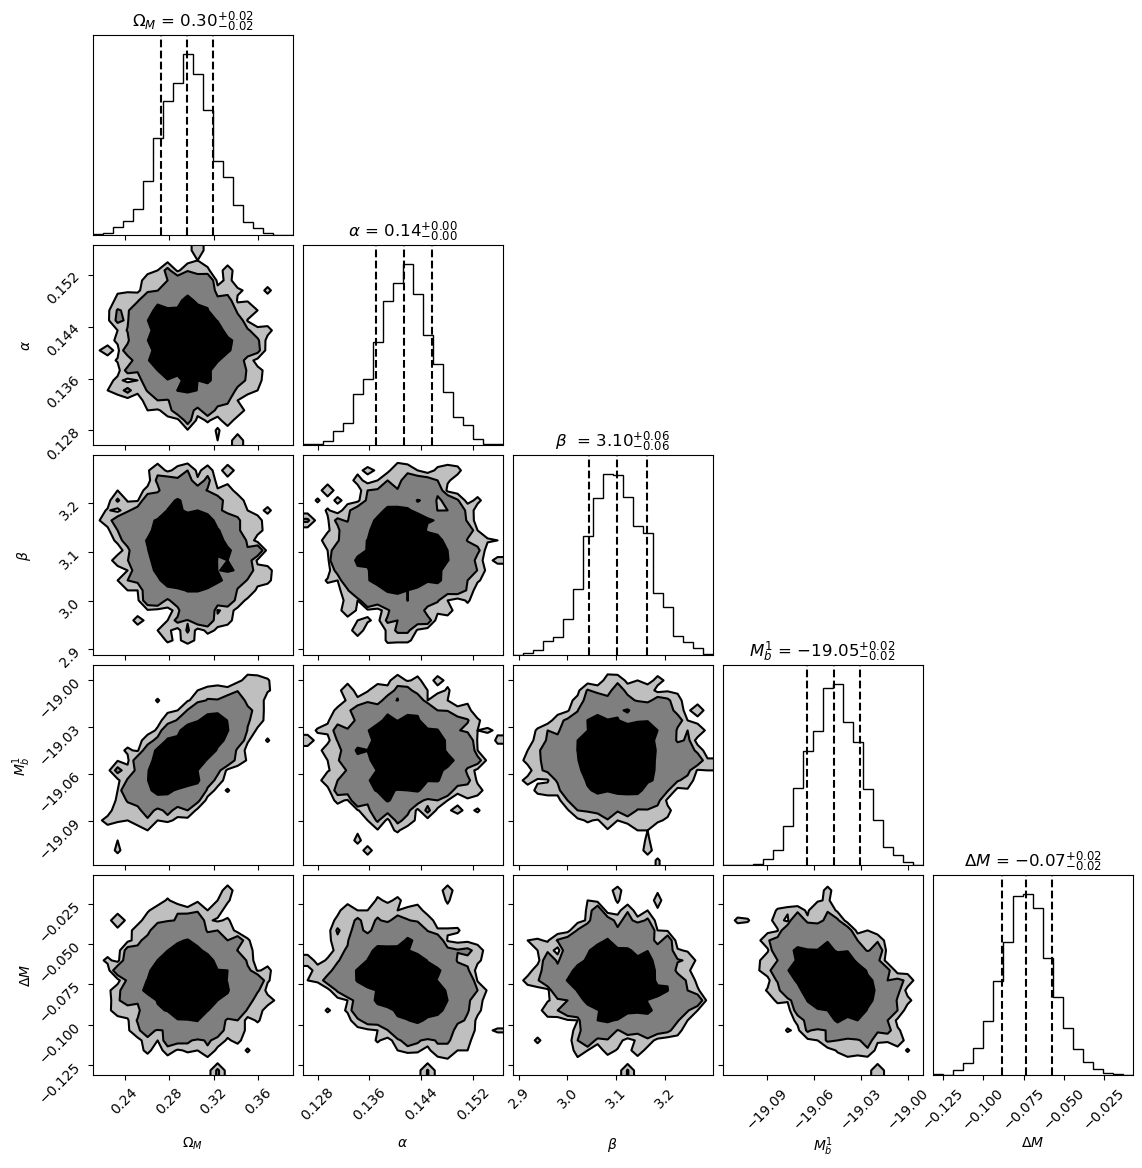

In [191]:
labels = ['$\\Omega_M$', '$\\alpha$', '$\\beta$ ', '$M^1_b$', '$\\Delta M$']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=False,levels=(0.68,0.95,0.99),fill_contours=True,plot_density=False,quantiles=[0.16, 0.5, 0.84])
fig.savefig('supernovaadj_100_100_200_cc.png')

In [115]:
Om, alpha, beta, M1b, dM1b = 0.23, 0.15, 3, -20, -0.07
    
mulcdm = mu_lcdm(zcmb, Om)
mudat = mu_dat(mb, x1, color, M1b, dM1b, alpha, beta)
res = mulcdm - mudat
    
    #sigma_mu = err2_mu(dmb, alpha, dx1, beta, dcolor, cov_m_s, cov_m_c, cov_s_c)

A = Amat(alpha, beta)
    
incov = np.linalg.inv(np.matmul(A,np.matmul(COV,A.transpose())))

xisq = np.matmul(res.transpose(), np.matmul(incov, res))
-0.5 * xisq

-20019.472131989336

In [127]:
samplespru = np.genfromtxt("adj_samples_1000-800-200_err1.txt")

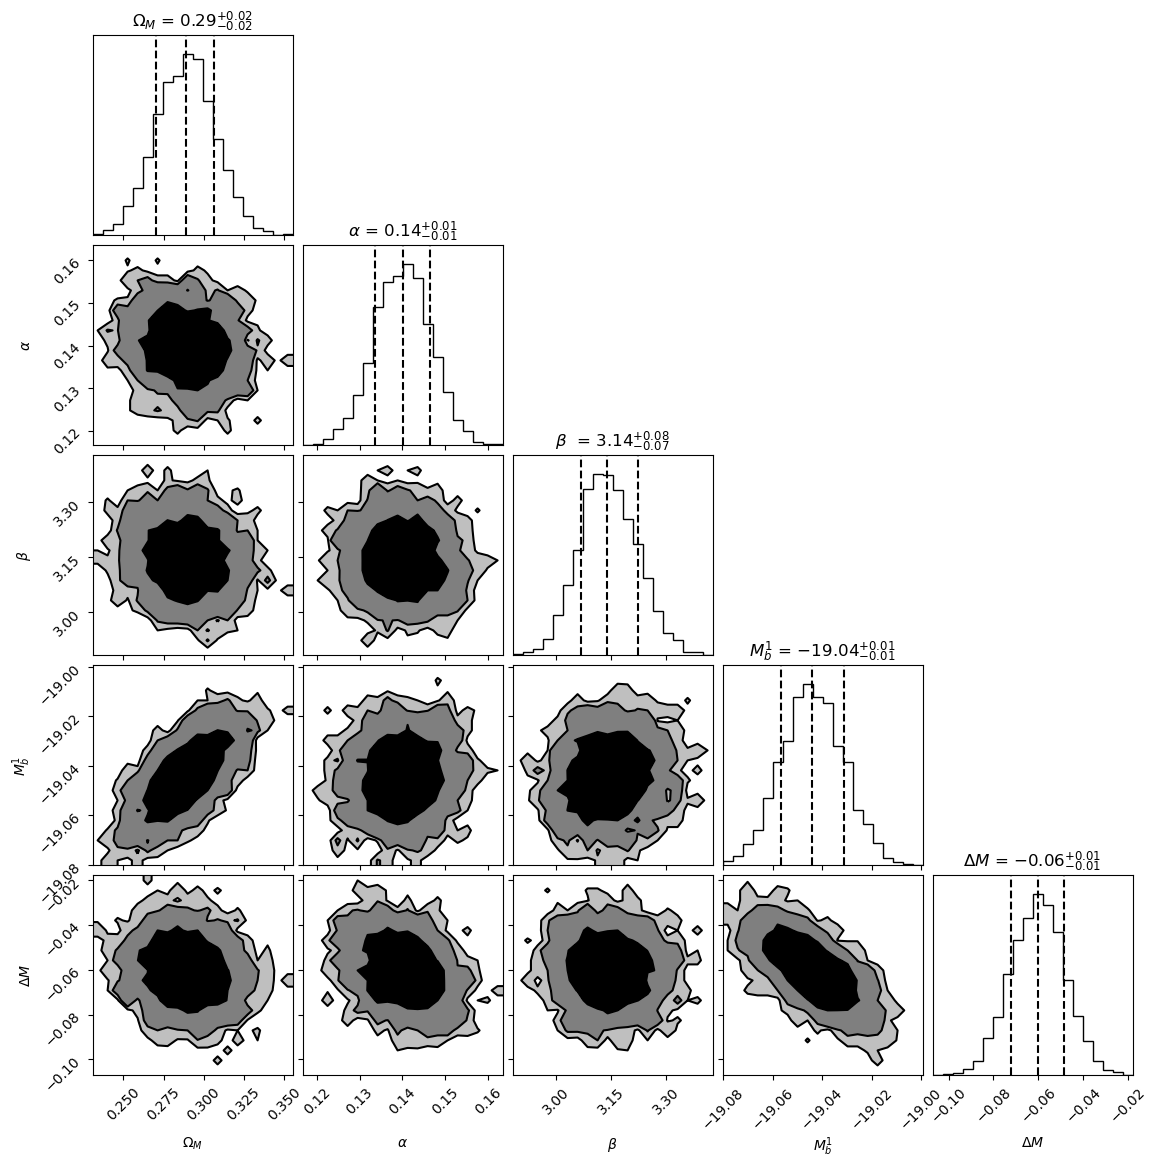

In [470]:
labels = ['$\\Omega_M$', '$\\alpha$', '$\\beta$ ', '$M^1_b$', '$\\Delta M$']
fig = corner.corner(samplespru[190000:],show_titles=True,labels=labels,plot_datapoints=False,levels=(0.68,0.95,0.99),fill_contours=True,plot_density=False,quantiles=[0.16, 0.5, 0.84])

In [151]:
%%time
Om, alpha, beta, M1b, dM1b = 0.289, 0.140, 3.139, -19.04, -0.060

mulcdm = mu_lcdm(zcmb, Om)
mudat = mu_dat(mb, x1, color, M1b, dM1b, alpha, beta)
res = mulcdm - mudat

sigma_mu = err2_mu(dmb, alpha, dx1, beta, dcolor, cov_m_s, cov_m_c, cov_s_c)
incov = np.linalg.inv(cov(sigma_mu, alpha, beta))

xisq = np.matmul(res.transpose(), np.matmul(incov, res))
xisq

CPU times: user 96.7 ms, sys: 11.9 ms, total: 109 ms
Wall time: 73.8 ms


684.1905520803888

In [153]:
%%time
Om, alpha, beta, M1b, dM1b = 0.3, 0.140, 2.97, -19.04, -0.060

mulcdm = mu_lcdm(zcmb, Om)
mudat = mu_dat(mb, x1, color, M1b, dM1b, alpha, beta)
res = mulcdm - mudat

A = Amat(alpha, beta) 
incov = np.linalg.inv(np.matmul(A,np.matmul(COV,A.transpose())) + diagerr)

xisq = np.matmul(res.transpose(), np.matmul(incov, res))

xisq

CPU times: user 448 ms, sys: 39.3 ms, total: 488 ms
Wall time: 278 ms


738.1743332336143

In [85]:
%%time
Om, alpha, beta, M1b, dM1b = 0.289, 0.140, 3.139, -19.04, -0.060

mulcdm = mu_lcdm(zcmb, Om)
mudat = mu_dat(mb, x1, color, M1b, dM1b, alpha, beta)
res = mudat - mulcdm

#Error Diagonal (solo derivadas)
sigma_mu = err2_mu(dmb, alpha, dx1, beta, dcolor, cov_m_s, cov_m_c, cov_s_c)
incov = np.linalg.inv(np.diagflat(sigma_mu) + diagerr)

xisq = np.matmul(res.transpose(), np.matmul(incov, res))
xisq

CPU times: user 92.7 ms, sys: 5.58 ms, total: 98.3 ms
Wall time: 72.7 ms


495.87935110739073